In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext                                    # Importing SparkContext
from pyspark.sql import SparkSession, Window, Row                   # Importing importing methods for creating a cluster
from pyspark.sql import functions as F                              # Importing SQL Functions
from pyspark.sql.functions import col, isnan, when, count           # Importing relevant dataframe functions
from pyspark.sql.functions import *                                 # Importing inbuilt SQL Functions
from pyspark.sql.types import *                                     # Importing SQL types

import matplotlib.pyplot as plt                                     # Popular plotting library
                                      
import seaborn as sns                                               # Advanced plotting library
from handyspark import *                                            # Helper library to plot graphs

from pyspark.ml.feature import VectorAssembler                      # For processing dataset for ML
from pyspark.ml.regression import LinearRegression                  # Importing mlib linear regression

import warnings                                                     # Importing warning to disable runtime warnings
warnings.filterwarnings("ignore")  


In [3]:
spark=SparkSession.builder.appName('diabetic').getOrCreate()

In [4]:
data = spark.read.csv('newd/diabetes.csv',inferSchema=True,header=True)

In [5]:
print("shape of dataset",(data.count(),len(data.columns)))

shape of dataset (2000, 9)


In [6]:
data.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          2|    138|           62|           35|      0|33.6|                   0.127| 47|      1|
|          0|     84|           82|           31|    125|38.2|                   0.233| 23|      0|
|          0|    145|            0|            0|      0|44.2|                    0.63| 31|      1|
|          0|    135|           68|           42|    250|42.3|                   0.365| 24|      1|
|          1|    139|           62|           41|    480|40.7|                   0.536| 21|      0|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



In [7]:
data.head(5)

[Row(Pregnancies=2, Glucose=138, BloodPressure=62, SkinThickness=35, Insulin=0, BMI=33.6, DiabetesPedigreeFunction=0.127, Age=47, Outcome=1),
 Row(Pregnancies=0, Glucose=84, BloodPressure=82, SkinThickness=31, Insulin=125, BMI=38.2, DiabetesPedigreeFunction=0.233, Age=23, Outcome=0),
 Row(Pregnancies=0, Glucose=145, BloodPressure=0, SkinThickness=0, Insulin=0, BMI=44.2, DiabetesPedigreeFunction=0.63, Age=31, Outcome=1),
 Row(Pregnancies=0, Glucose=135, BloodPressure=68, SkinThickness=42, Insulin=250, BMI=42.3, DiabetesPedigreeFunction=0.365, Age=24, Outcome=1),
 Row(Pregnancies=1, Glucose=139, BloodPressure=62, SkinThickness=41, Insulin=480, BMI=40.7, DiabetesPedigreeFunction=0.536, Age=21, Outcome=0)]

In [8]:
data.describe().show()

+-------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------------+------------------+------------------+
|summary|      Pregnancies|           Glucose|     BloodPressure|    SkinThickness|          Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------------+------------------+------------------+
|  count|             2000|              2000|              2000|             2000|             2000|              2000|                    2000|              2000|              2000|
|   mean|           3.7035|          121.1825|           69.1455|           20.935|           80.254|32.192999999999984|     0.47092999999999974|           33.0905|             0.342|
| stddev|3.306063032730656|32.068635649902916|19.188314815604098|16.103242909926

In [9]:
data.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [10]:
data.dtypes

[('Pregnancies', 'int'),
 ('Glucose', 'int'),
 ('BloodPressure', 'int'),
 ('SkinThickness', 'int'),
 ('Insulin', 'int'),
 ('BMI', 'double'),
 ('DiabetesPedigreeFunction', 'double'),
 ('Age', 'int'),
 ('Outcome', 'int')]

In [11]:
from pyspark.sql.functions import *
for i in data.columns[1:6]:
    data1=data.agg({i:"mean"}).first()[0]
    print("Mean value {} is {}".format(i,int(data1)))
    data = data.withColumn(i,when(data[i]==0,int(data1)).otherwise(data[i]))

Mean value Glucose is 121
Mean value BloodPressure is 69
Mean value SkinThickness is 20
Mean value Insulin is 80
Mean value BMI is 32


In [12]:
data.columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

### Data Post-Processing


In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
assembler = VectorAssembler(inputCols=['Pregnancies',
 'Glucose',
 'BloodPressure',
 'BMI',
 'Age'],outputCol='featured')

In [14]:
output = assembler.transform(data)
output.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+--------------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|            featured|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+--------------------+
|          2|    138|           62|           35|     80|33.6|                   0.127| 47|      1|[2.0,138.0,62.0,3...|
|          0|     84|           82|           31|    125|38.2|                   0.233| 23|      0|[0.0,84.0,82.0,38...|
|          0|    145|           69|           20|     80|44.2|                    0.63| 31|      1|[0.0,145.0,69.0,4...|
|          0|    135|           68|           42|    250|42.3|                   0.365| 24|      1|[0.0,135.0,68.0,4...|
|          1|    139|           62|           41|    480|40.7|                   0.536| 21|      0|[1.0,139.0,62.0,4...|
+-----------+-------+-----------

In [15]:
output.columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome',
 'featured']

In [16]:
final_data=output.select("featured","Outcome")
final_data.show(5)

+--------------------+-------+
|            featured|Outcome|
+--------------------+-------+
|[2.0,138.0,62.0,3...|      1|
|[0.0,84.0,82.0,38...|      0|
|[0.0,145.0,69.0,4...|      1|
|[0.0,135.0,68.0,4...|      1|
|[1.0,139.0,62.0,4...|      0|
+--------------------+-------+
only showing top 5 rows



In [17]:
train_data,test_data=final_data.randomSplit([0.8,0.2])

### Linear Regression Using PySpark

In [18]:
lr=LinearRegression(featuresCol="featured",labelCol="Outcome")
lr_model=lr.fit(train_data)

In [19]:
lr_model.intercept

-0.9274057809054377

In [20]:
lr_model.coefficients

DenseVector([0.0203, 0.0063, -0.0004, 0.0121, 0.0019])

In [21]:
pred_train = lr_model.evaluate(train_data)

In [22]:
pred_train.r2

0.28442025034109264

In [23]:
pred_train.predictions.show()

+--------------------+-------+--------------------+
|            featured|Outcome|          prediction|
+--------------------+-------+--------------------+
|[0.0,57.0,60.0,21...|      0| -0.2037197665847359|
|[0.0,67.0,76.0,45...|      0| 0.09667618316416071|
|[0.0,67.0,76.0,45...|      0| 0.09667618316416071|
|[0.0,73.0,69.0,21...|      0|-0.19558481539681205|
|[0.0,73.0,69.0,21...|      0|-0.19558481539681205|
|[0.0,74.0,52.0,27...|      0|-0.10685325489076847|
|[0.0,74.0,52.0,27...|      0|-0.10685325489076847|
|[0.0,74.0,52.0,27...|      0|-0.10685325489076847|
|[0.0,78.0,88.0,36...|      0|0.010766905896229972|
|[0.0,78.0,88.0,36...|      0|0.010766905896229972|
|[0.0,84.0,64.0,35...|      0|0.045472252827062354|
|[0.0,84.0,64.0,35...|      0|0.045472252827062354|
|[0.0,84.0,64.0,35...|      0|0.045472252827062354|
|[0.0,84.0,82.0,38...|      0| 0.07058654275481369|
|[0.0,84.0,82.0,38...|      0| 0.07058654275481369|
|[0.0,84.0,82.0,38...|      0| 0.07058654275481369|
|[0.0,86.0,6

### Model Evaluation on Test Set

In [24]:
pred_test=lr_model.evaluate(test_data)

In [25]:
pred_test.predictions.show()

+--------------------+-------+--------------------+
|            featured|Outcome|          prediction|
+--------------------+-------+--------------------+
|[0.0,57.0,60.0,21...|      0| -0.2037197665847359|
|[0.0,84.0,82.0,38...|      0| 0.07058654275481369|
|[0.0,91.0,80.0,32...|      0|0.053058615220037075|
|[0.0,95.0,80.0,36...|      0| 0.12576656540472242|
|[0.0,97.0,64.0,36...|      0| 0.14689762040876664|
|[0.0,100.0,70.0,3...|      0|  0.0829350391770789|
|[0.0,100.0,88.0,4...|      0|   0.287807205087405|
|[0.0,100.0,88.0,4...|      0|   0.287807205087405|
|[0.0,101.0,64.0,2...|      0|-0.02659306394627825|
|[0.0,101.0,64.0,2...|      0|-0.02659306394627825|
|[0.0,102.0,64.0,4...|      0| 0.21646001759527422|
|[0.0,102.0,75.0,3...|      0| 0.10783592098601846|
|[0.0,104.0,64.0,2...|      0| 0.07825331994678963|
|[0.0,105.0,64.0,4...|      0| 0.24809912574766124|
|[0.0,106.0,70.0,3...|      0| 0.22642664016600733|
|[0.0,107.0,76.0,4...|      0|  0.3052633116078902|
|[0.0,117.0,

In [26]:
pred_test.r2

0.3569867277825006

### Logistic regression

In [27]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('diabetics project').getOrCreate()

In [28]:
import matplotlib.pyplot as plt

In [29]:
df=spark.read.csv('newd/diabetes.csv',inferSchema=True,header=True)

In [30]:
df.show(4)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          2|    138|           62|           35|      0|33.6|                   0.127| 47|      1|
|          0|     84|           82|           31|    125|38.2|                   0.233| 23|      0|
|          0|    145|            0|            0|      0|44.2|                    0.63| 31|      1|
|          0|    135|           68|           42|    250|42.3|                   0.365| 24|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 4 rows



In [31]:
df.columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [32]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [33]:
print((df.count(),len(df.columns)))

(2000, 9)


In [34]:
df.groupby('outcome').count().show()

+-------+-----+
|outcome|count|
+-------+-----+
|      1|  684|
|      0| 1316|
+-------+-----+



In [35]:
df.describe().show()

+-------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------------+------------------+------------------+
|summary|      Pregnancies|           Glucose|     BloodPressure|    SkinThickness|          Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------------+------------------+------------------+
|  count|             2000|              2000|              2000|             2000|             2000|              2000|                    2000|              2000|              2000|
|   mean|           3.7035|          121.1825|           69.1455|           20.935|           80.254|32.192999999999984|     0.47092999999999974|           33.0905|             0.342|
| stddev|3.306063032730656|32.068635649902916|19.188314815604098|16.103242909926

### check Null values

In [36]:
for col in df.columns:
    print(col +":",df[df[col].isNull()].count())

Pregnancies: 0
Glucose: 0
BloodPressure: 0
SkinThickness: 0
Insulin: 0
BMI: 0
DiabetesPedigreeFunction: 0
Age: 0
Outcome: 0


In [37]:
df.columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [38]:
def count_zeros():
    column_list=['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
    for i in column_list:
        print(i+":",df[df[i]==0].count())
count_zeros()

Glucose: 13
BloodPressure: 90
SkinThickness: 573
Insulin: 956
BMI: 28


### Replacing zeros with the mean value

In [39]:
from pyspark.sql.functions import *
for i in df.columns[1:6]:
    data=df.agg({i:"mean"}).first()[0]
    print("Mean value {} is {}".format(i,int(data)))
    df = df.withColumn(i,when(df[i]==0,int(data)).otherwise(df[i]))

Mean value Glucose is 121
Mean value BloodPressure is 69
Mean value SkinThickness is 20
Mean value Insulin is 80
Mean value BMI is 32


In [40]:
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          2|    138|           62|           35|     80|33.6|                   0.127| 47|      1|
|          0|     84|           82|           31|    125|38.2|                   0.233| 23|      0|
|          0|    145|           69|           20|     80|44.2|                    0.63| 31|      1|
|          0|    135|           68|           42|    250|42.3|                   0.365| 24|      1|
|          1|    139|           62|           41|    480|40.7|                   0.536| 21|      0|
|          0|    173|           78|           32|    265|46.5|                   1.159| 58|      0|
|          4|     99|           72|           17|     80|25.6|                   0.294| 28|      0|


In [58]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pregnancies,2000,3.7035,3.306063032730656,0,17
Glucose,2000,121.969,30.533214334373536,44,199
BloodPressure,2000,72.2505,11.970354817098098,24,122
SkinThickness,2000,26.665,10.054218948249018,7,110
Insulin,2000,118.494,88.41897942162065,14,744
Age,2000,33.0905,11.786423106049496,21,81
Outcome,2000,0.342,0.4744982342297426,0,1


<AxesSubplot:xlabel='Pregnancies', ylabel='Count'>

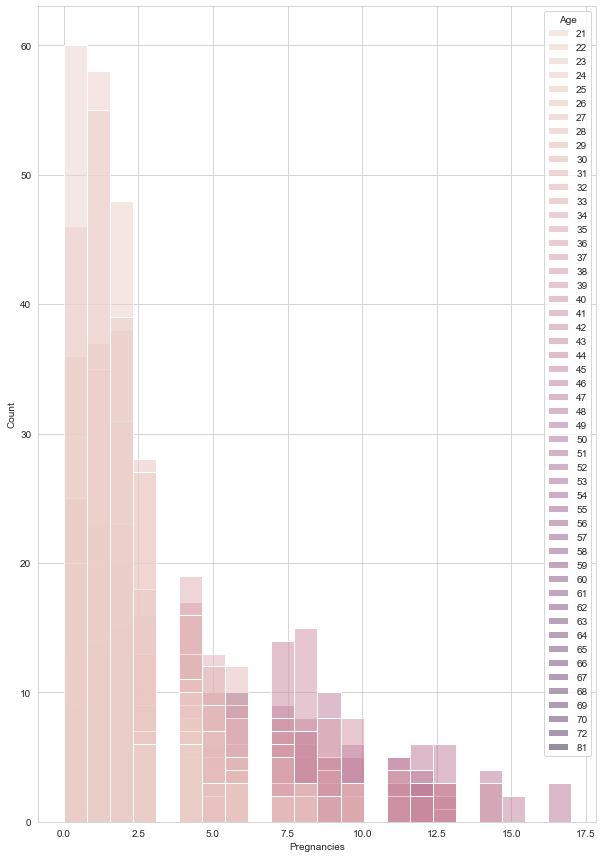

In [41]:
import seaborn as sns
plt.figure(figsize=(10,15))
sf1=df.toPandas()
sns.set_style('whitegrid')
sns.histplot(x='Pregnancies',hue='Age',data=sf1)

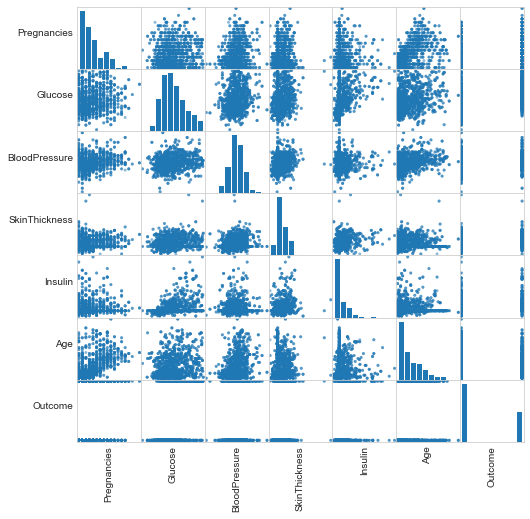

In [59]:
from pandas.plotting import scatter_matrix
numeric_data = df.select(numeric_features).toPandas()

axs = scatter_matrix(numeric_data, figsize=(8, 8));

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

### Correlation & Feature Selection

In [42]:
for i in df.columns:
    print("correlation to outcome for {} is {}".format(i,df.stat.corr('outcome',i)))

correlation to outcome for Pregnancies is 0.22443699263363961
correlation to outcome for Glucose is 0.48796646527321064
correlation to outcome for BloodPressure is 0.17171333286446713
correlation to outcome for SkinThickness is 0.1659010662889893
correlation to outcome for Insulin is 0.1711763270226193
correlation to outcome for BMI is 0.2827927569760082
correlation to outcome for DiabetesPedigreeFunction is 0.1554590791569403
correlation to outcome for Age is 0.23650924717620253
correlation to outcome for Outcome is 1.0


In [43]:
df.columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [44]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age'],outputCol="features")
output_data=assembler.transform(df)

In [45]:
output_data.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)
 |-- features: vector (nullable = true)



### Model Creation

In [46]:
from pyspark.ml.classification import LogisticRegression
final_data = output_data.select('features','Outcome')
final_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Outcome: integer (nullable = true)



In [47]:
train,test = final_data.randomSplit([0.7,0.3])
Model = LogisticRegression(labelCol="Outcome")
model=Model.fit(train)

In [48]:
summary=model.summary
summary.predictions.describe().show()

+-------+------------------+-------------------+
|summary|           Outcome|         prediction|
+-------+------------------+-------------------+
|  count|              1398|               1398|
|   mean|0.3419170243204578| 0.2625178826895565|
| stddev|0.4745216951930554|0.44016000300025326|
|    min|               0.0|                0.0|
|    max|               1.0|                1.0|
+-------+------------------+-------------------+



### Evaluate And Save Model

In [49]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
pred = model.evaluate(test)

In [50]:
pred.predictions.show(10)

+--------------------+-------+--------------------+--------------------+----------+
|            features|Outcome|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|[0.0,57.0,60.0,20...|      0|[3.72453451095047...|[0.97644394652305...|       0.0|
|[0.0,73.0,69.0,20...|      0|[4.14320058836625...|[0.98437601298145...|       0.0|
|[0.0,73.0,69.0,20...|      0|[4.14320058836625...|[0.98437601298145...|       0.0|
|[0.0,74.0,52.0,10...|      0|[3.63249618007221...|[0.97423150102305...|       0.0|
|[0.0,78.0,88.0,29...|      0|[2.70176119353162...|[0.93713048799013...|       0.0|
|[0.0,84.0,64.0,22...|      0|[2.45519874877093...|[0.92094079500972...|       0.0|
|[0.0,84.0,82.0,31...|      0|[2.72155885578044...|[0.93828686039572...|       0.0|
|[0.0,86.0,68.0,32...|      0|[2.75191104220093...|[0.94002118762156...|       0.0|
|[0.0,93.0,60.0,25...|      0|[2.71139408361381...|[0.93769564421618...|    

In [51]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='Outcome')
evaluator.evaluate(model.transform(test))

0.8464254192409532

### Saving creating model as module

model.save("diabeticlogregmodel")

from pyspark.ml.classification import LogisticRegressionModel
model = LogisticRegressionModel.load('diabeticlogregmodel')

### Prediction on New data with saved model

In [53]:
test_df1 = spark.read.csv("newd/new_test.csv",header = True,inferSchema=True)

In [54]:
test_df1.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)



In [55]:
test_data= assembler.transform(test_df1)

In [56]:
result= model.transform(test_data)
result.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [57]:
result.select('features','prediction').show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[1.0,190.0,78.0,3...|       1.0|
|[0.0,80.0,84.0,36...|       0.0|
|[2.0,138.0,82.0,4...|       1.0|
|[1.0,110.0,63.0,4...|       1.0|
+--------------------+----------+



### RandomForestClassifier

In [60]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='Outcome', 
                            featuresCol='features',
                            maxDepth=5)
model = rf.fit(train)
rf_predictions = model.transform(test)

In [61]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'Outcome', metricName = 'accuracy')
print('Random Forest classifier Accuracy:', multi_evaluator.evaluate(rf_predictions))

Random Forest classifier Accuracy: 0.8305647840531561


### DecisionTreeClassifier

In [63]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Outcome', maxDepth = 3)
dtModel = dt.fit(train)
dt_predictions = dtModel.transform(test)
print(multi_evaluator.evaluate(dt_predictions))


0.7657807308970099


In [65]:
dt_predictions.columns

['features', 'Outcome', 'rawPrediction', 'probability', 'prediction']

In [64]:
dt_predictions.show(10)

+--------------------+-------+-------------+--------------------+----------+
|            features|Outcome|rawPrediction|         probability|prediction|
+--------------------+-------+-------------+--------------------+----------+
|[0.0,57.0,60.0,20...|      0|[705.0,165.0]|[0.81034482758620...|       0.0|
|[0.0,73.0,69.0,20...|      0|[705.0,165.0]|[0.81034482758620...|       0.0|
|[0.0,73.0,69.0,20...|      0|[705.0,165.0]|[0.81034482758620...|       0.0|
|[0.0,74.0,52.0,10...|      0|[705.0,165.0]|[0.81034482758620...|       0.0|
|[0.0,78.0,88.0,29...|      0|[705.0,165.0]|[0.81034482758620...|       0.0|
|[0.0,84.0,64.0,22...|      0|[705.0,165.0]|[0.81034482758620...|       0.0|
|[0.0,84.0,82.0,31...|      0|[705.0,165.0]|[0.81034482758620...|       0.0|
|[0.0,86.0,68.0,32...|      0|[705.0,165.0]|[0.81034482758620...|       0.0|
|[0.0,93.0,60.0,25...|      0|[705.0,165.0]|[0.81034482758620...|       0.0|
|[0.0,93.0,100.0,3...|      0|[705.0,165.0]|[0.81034482758620...|       0.0|